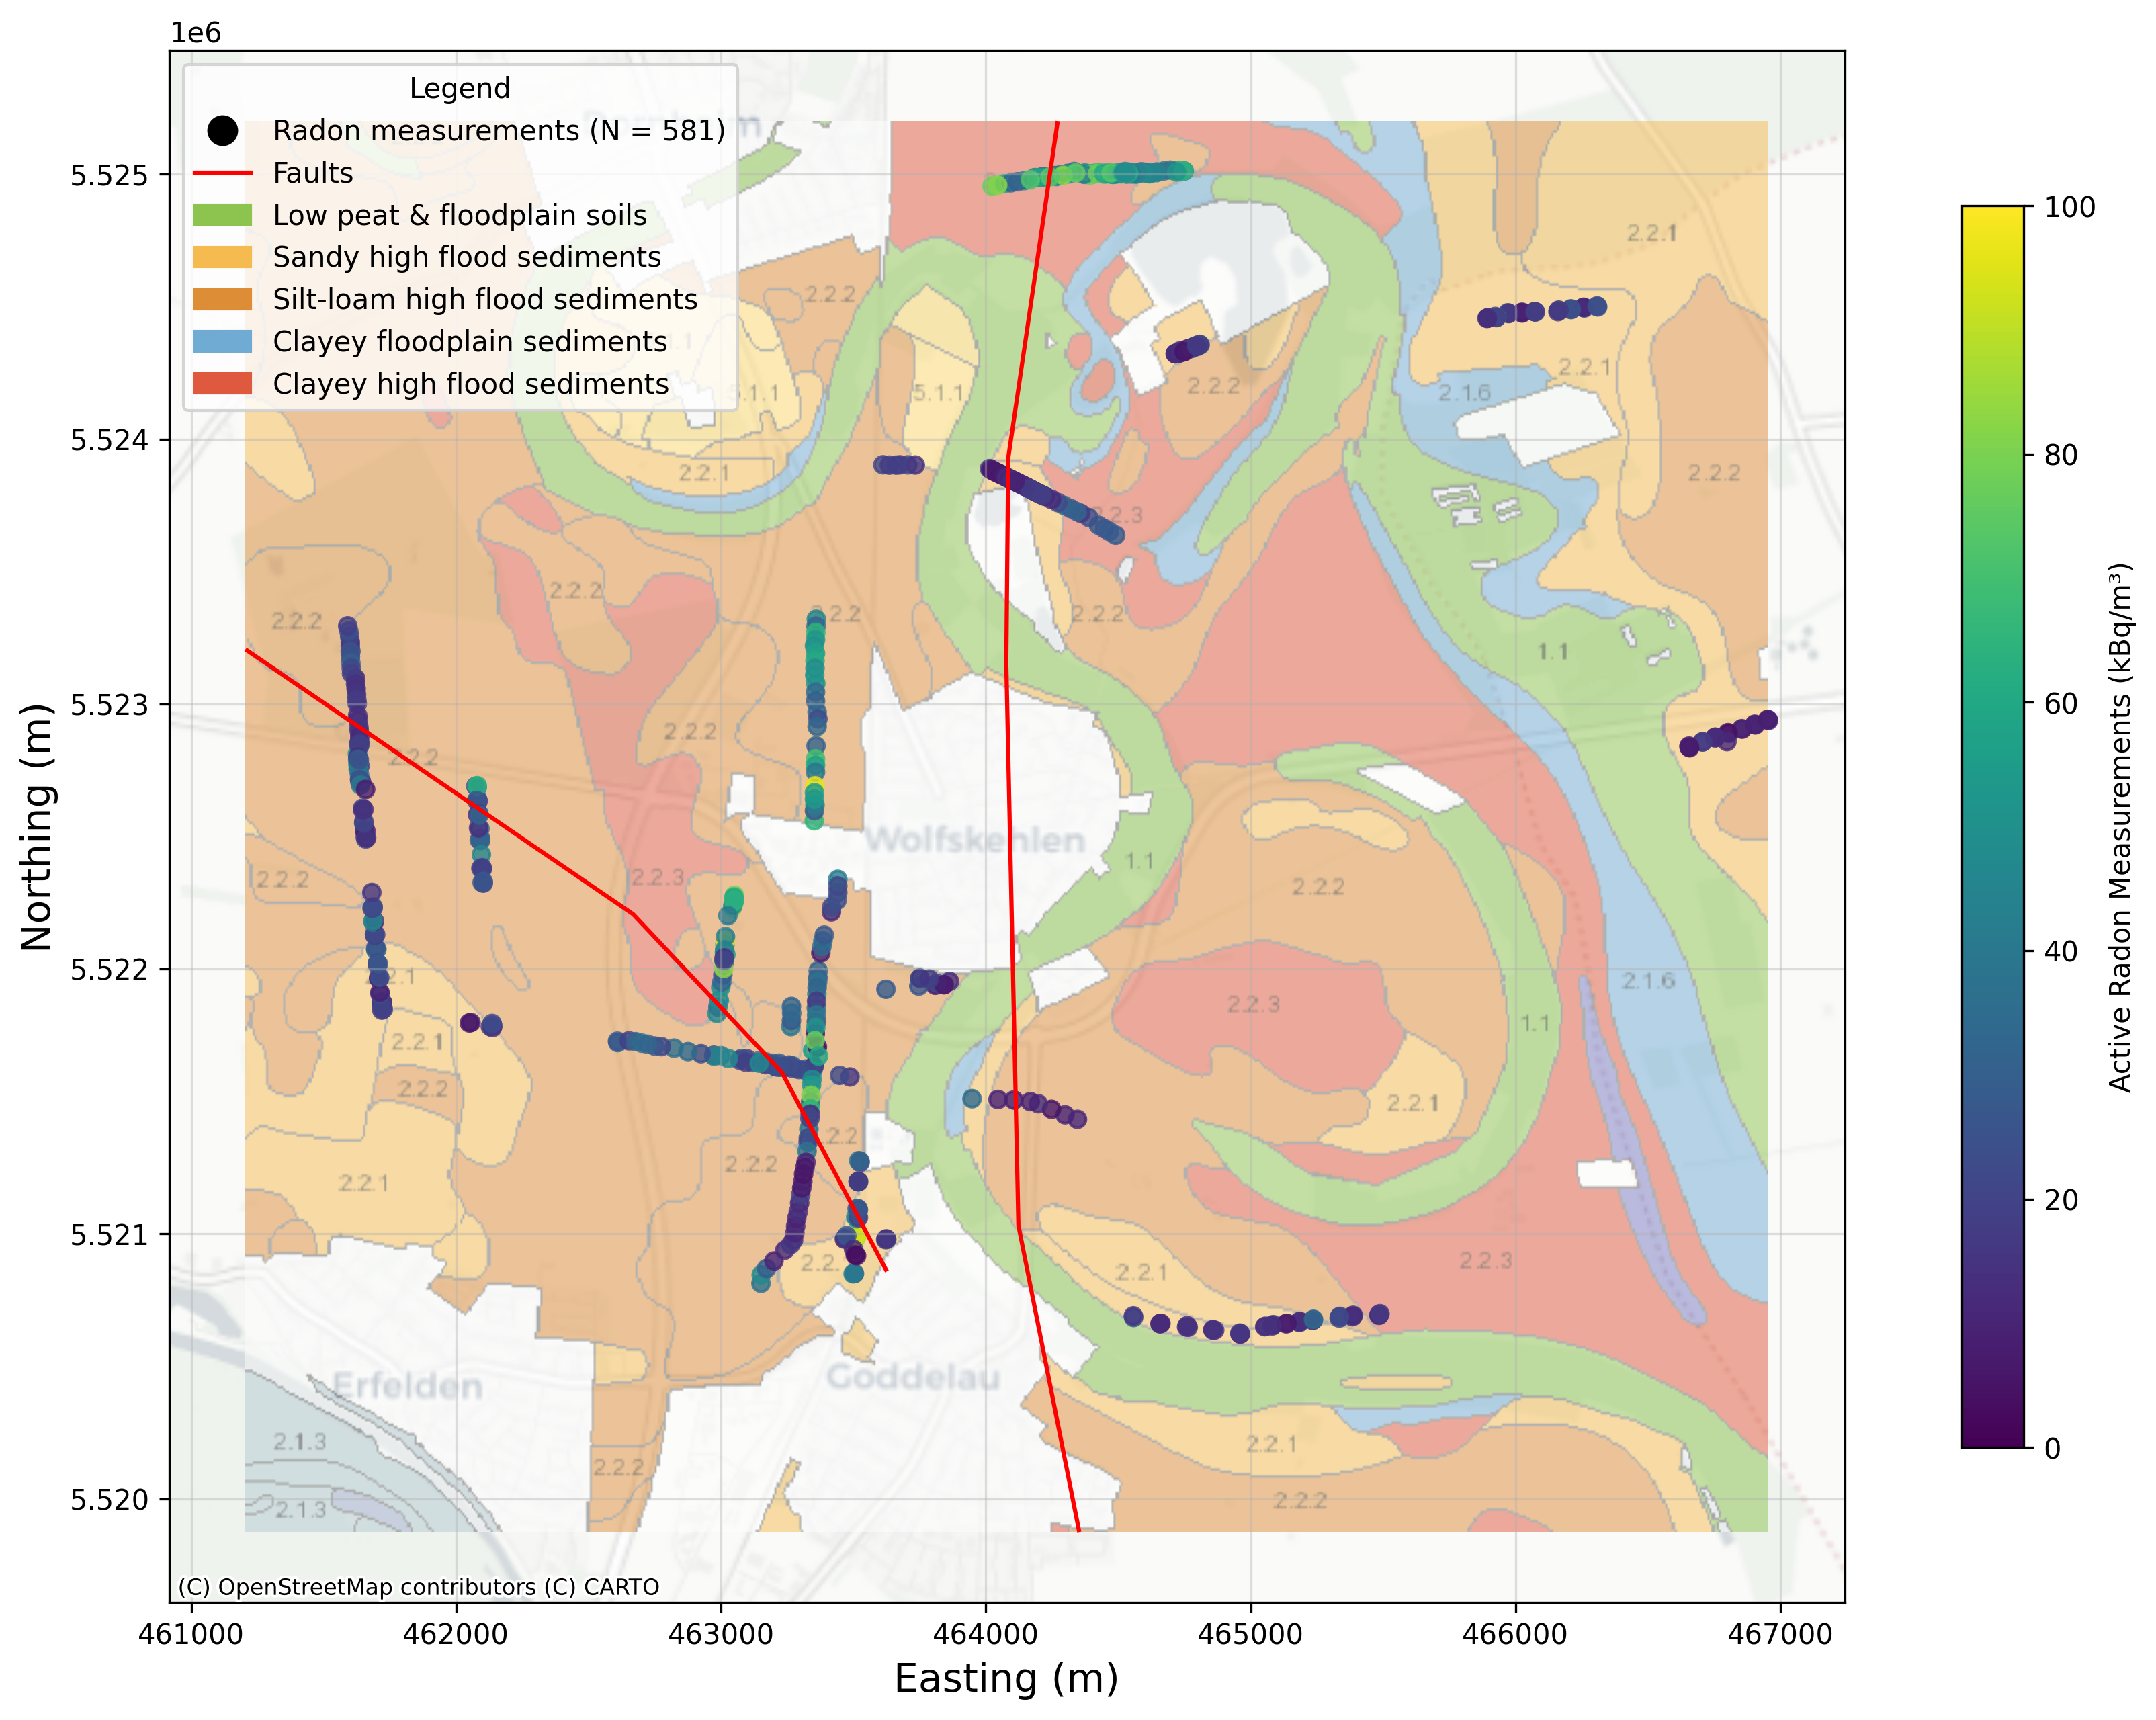

In [4]:
import matplotlib.pyplot as plt
from owslib.wms import WebMapService
import geopandas as gpd
from PIL import Image
import io
import contextily as ctx
from matplotlib.lines import Line2D
import pandas as pd
import matplotlib.patches as mpatches

def load_and_convert_to_geodf(filepath, x='East_Coordinate', y='North_Coordinate', crs='epsg:32632'):
    df = pd.read_excel(filepath)
    df['Radon_Level'] = df['Radon_Level'] / 1000
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[x], df[y]), crs=crs)
    return gdf.to_crs(epsg=32632)

kzm_gdf = load_and_convert_to_geodf('data.xlsx')

fig, ax = plt.subplots(figsize=(15, 10), dpi=300)
ax.set_xlabel('Easting (m)', fontsize=14)
ax.set_ylabel('Northing (m)', fontsize=14)
ax.grid(alpha=0.4)

kzm_gdf.plot(ax=ax, marker='o', column='Radon_Level', cmap='viridis', vmin=0, vmax=100, legend=True, alpha=0.8,
             legend_kwds={'label': "Active Radon Measurements (kBq/m³)", 'orientation': "vertical", 'shrink': 0.8})

faults_gdf = gpd.read_file('Distance2Fault/Shapefiles/faults_extended/faults_extended.shp').to_crs(epsg=32632)
faults_gdf.plot(ax=ax, color='red', linewidth=1.5)

combined_gdf = pd.concat([kzm_gdf, faults_gdf])
bounds = combined_gdf.total_bounds
padding = 0.05
ax.set_xlim(bounds[0] - padding*(bounds[2] - bounds[0]), bounds[2] + padding*(bounds[2] - bounds[0]))
ax.set_ylim(bounds[1] - padding*(bounds[3] - bounds[1]), bounds[3] + padding*(bounds[3] - bounds[1]))
ctx.add_basemap(ax, crs=combined_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

wms_url = 'https://geodienste-umwelt.hessen.de/arcgis/services/boden/bfd50/MapServer/WmsServer?'
wms = WebMapService(wms_url)
layer = list(wms.contents.keys())[5]

bbox = combined_gdf.total_bounds
img = wms.getmap(layers=[layer], srs='EPSG:32632', bbox=bbox, size=(800, 600), format='image/png')
image = Image.open(io.BytesIO(img.read()))

ax.imshow(image, extent=[bbox[0], bbox[2], bbox[1], bbox[3]], interpolation='bilinear', alpha=0.5)

num_measurements = len(kzm_gdf)
legend_handles = [
    Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label=f'Radon measurements (N = {num_measurements})'),
    Line2D([], [], color='red', marker='', linestyle='-', markersize=10, label='Faults')
]

legend_colors = ['#8DC44F', '#F5BB51', '#DE8D37', '#70ABD4', '#DE593D']
legend_labels = ['Low peat & floodplain soils', 'Sandy high flood sediments', 'Silt-loam high flood sediments', 
                 'Clayey floodplain sediments', 'Clayey high flood sediments']

for color, label in zip(legend_colors, legend_labels):
    legend_handles.append(mpatches.Patch(color=color, label=label))

ax.legend(handles=legend_handles, loc='upper left', title="Legend")
ax.set_aspect('equal')

#plt.savefig('map_with_legends.svg', transparent=True)
#plt.savefig('Figure1_map.pdf')
plt.show()
